This is the Jupyter notebook associated with the first 3 posts on the Kid Quant blog related to fractional differencing. Below, I generate all the tables/graphs I use to complete the post as well as any other functions/computations. I have a seperate latex file that runs through the derivation of fractional differencing weights which you can find in the same repo. 

I did my best to try and comment on most of my code (at least for now) just in case we have any python newbies out there interested (not to say that I'm not a newbie myself...)

For now, I'll be using Quandl's API to get end of day prices for the examples I go through below. 

### Setup

In [14]:
#import all necessary libraries for analysis
import math
import numpy as np
import pandas as pd
import quandl
import statsmodels.tsa.stattools as st

#plotting libraries
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt

import seaborn as sns

#Initialize figure size (in inches)
plt.rcParams['figure.figsize'] = [10,5]

pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

import os

In [2]:
#set API key (saved locally on machine)
quandl.ApiConfig.api_key = os.environ.get('quandl_api_key')

In [3]:
tsla = quandl.get('WIKI/TSLA')
#as a sanity check
tsla.head(5)

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2010-06-29,19.0,25.0,17.5,23.9,18766300.0,0.0,1.0,19.0,25.0,17.5,23.9,18766300.0
2010-06-30,25.8,30.4,23.3,23.8,17187100.0,0.0,1.0,25.8,30.4,23.3,23.8,17187100.0
2010-07-01,25.0,25.9,20.3,22.0,8218800.0,0.0,1.0,25.0,25.9,20.3,22.0,8218800.0
2010-07-02,23.0,23.1,18.7,19.2,5139800.0,0.0,1.0,23.0,23.1,18.7,19.2,5139800.0
2010-07-06,20.0,20.0,15.8,16.1,6866900.0,0.0,1.0,20.0,20.0,15.8,16.1,6866900.0


First, lets create a simple time-series graph of daily TSLA stock prices below.

/Users/28422/Desktop/Blog_files/jupyter-env/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


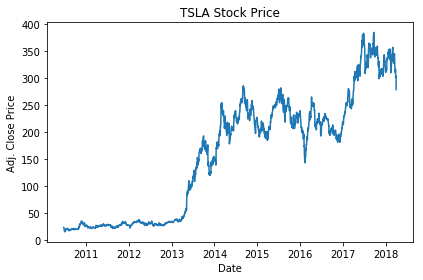

In [4]:
plt.ylabel("Adj. Close Price")
plt.xlabel("Date")
plt.title("TSLA Stock Price")
plt.tight_layout()
plt.plot(tsla.index, tsla['Adj. Close'])

Mean & Variance formulas for each respective observation $x_i$

Mean $$ \mu = \frac{\sum_{i=1}^{n}x_i}{n}$$

Variance $$\sigma^2 = \frac{\sum_{i=1}^{n}(x_i - \mu)^2} {n}$$

Below, I use numpy to find the daily returns of Tesla stock. This code may seem a bit convoluted but think of it as an exercise in vectorizing your code which can be extremely useful when looking at larger sets of data. The memory buffers for numpy arrays are stored at the C level so it makes the computing much faster (due to cache locality and heavily optimized computing). 



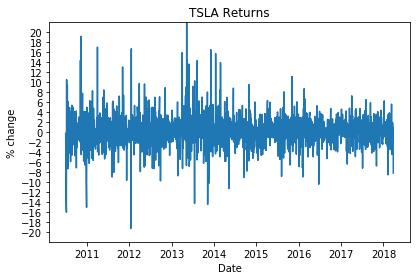

In [5]:
#extract close price values to get numpy array of values
price_list = tsla['Adj. Close'].values

#shift price list by one down and replace first entry with na value
shifted_prices = np.roll(price_list, shift=1, axis=0)
shifted_prices[:1] = np.nan

#calculate returns numpy array
tsla_returns = ((price_list - shifted_prices)/shifted_prices)*100

#plot graph of returns below
plt.ylabel("% change")
plt.yticks(np.arange(-20,21,2))
plt.ylim(-22,22)

plt.xlabel("Date")
plt.title("TSLA Returns")
plt.tight_layout()
plt.plot(tsla.index, tsla_returns)


### Fractional Differencing Part #1: Finding weights & Formula

Now that that's out of the way, lets get down to the fun part of this exercise, the implementation for fractional differencing. Looking at the sequence of weights, we recognize something quite useful:

   
For $k = 1,..., \infty$, if $w_0 = 1$, the weights can be generated iteratively as:

$$w_k = -w_{k-1} \frac{d-k+1}{k}$$

Below we code up the implementation for a weighting function given a differencing factor (d) and length of series (size). (Note: this code is directly taken and slightly changed from the book Advances in Financial Machine Learning. I am not attempting to claim this code as my own, just simply re-formatting it and using it for educational purposes.)


In [6]:
"""Computes the weights for our fractionally differenced features up to a given threshold
   requirement for fixed-window fractional differencing. 
    Args:
        d: A float representing the differencing factor
        length: An int length of series to be differenced
        threshold: A float representing the minimum threshold to include weights for
    Returns:
        A numpy array containing the weights to be applied to our time series
"""
def findWeights_FFD(d, length, threshold):
    #set first weight to be a 1 and k to be 1
    w, k = [1.], 1
    w_curr = 1
    
    #while we still have more weights to process, do the following:
    while(k < length):
        
        w_curr = (-w[-1]*(d-k+1))/k
        #if the current weight is below threshold, exit loop
        if(abs(w_curr) <= threshold):
            
            break
        #append coefficient to list if it passes above threshold condition
        w.append(w_curr)
        #increment k
        k += 1
    #make sure to convert it into a numpy array and reshape from a single row to a single
        # column so they can be applied to time-series values easier
    w = np.array(w[::-1]).reshape(-1,1)
    
    return w

So, how exactly do we go about fractionally differencing a (finite) time series? Well we can't really because of data limitations (can only have so much computational and memory overhead when doing these computations, however small each one may be). 

We can compute this using Fixed-Window fractional differencing. Simply, we drop weights when their values drop below a certain threshold that we identified above. Then, we pre-process our  series, multiply the weights by the numbers to difference them by a factor of d and repeat for all valid series values. The function below does this. 

In [7]:
"""Computes fractionally differenced series 
    Args:
        d: A float representing the differencing factor (any positive fractional)
        series: A pandas dataframe with one or more columns of time-series values to be differenced
        threshold: Threshold value past which we ignore weights 
            (cutoff weight for window)
    Returns: 
        diff_series: A numpy array of differenced series by d. 
"""
def fracDiff(series, d, threshold = 1e-5):
    #compute weights using function above
    weights = findWeights_FFD(d, len(series), threshold)
    width = len(weights) - 1
    
    df = {}
    #for each series to be differenced, apply weights to appropriate prices and save 
    for name in series.columns:
        
        #forward fill through unavailable prices and create a temporary series to hold values
        curr_series = series[[name]].fillna(method='ffill').dropna()
        df_temp = pd.Series()
        
        #loop through all values that fall into range to be fractionally differenced
        for iloc1 in range(width, curr_series.shape[0]):
            
            #set values for first and last time-series point to be used in current pass of fractional
                #difference
            loc0 = curr_series.index[iloc1-width]
            loc1 = curr_series.index[iloc1]
            
            #make sure current value is valid
            if not np.isfinite(curr_series.loc[loc1,name]):
                continue
            
            #dot product of weights with values from first and last indices
            df_temp[loc1]= np.dot(weights.T, curr_series.loc[loc0:loc1])[0,0]
            
        df[name] = df_temp.copy(deep=True)
    df = pd.concat(df, axis=1)
            
    return df
    

Now, this code may seem slightly confusing so I'm going to go through it a little just to make it clear. 

1. First, find the length of weights that are above our threshold value (essentially, this is the number of time-series values we're going to need to derive each fractionally differenced price. It is also the first index at which we can start fractionally differencing prices since the Fixed-Window Method has a 'Fixed' number of points being used.
2. We forward fill any NA values (a more detailed explanation can be found [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html#pandas.DataFrame.fillna) ) and create a temporary dataframe to store our fractionally differenced values.
3. We find the first and last indices that will be used in computing our fractional difference and we take the dot product of the weights and respective values.


### Fractional Differencing Part #2: Test-Run/Sanity Check

As a sanity check, I go through an example and plot the results just to make sure the code is doing what I expect it to be. 

In [32]:
test_series = tsla[['Adj. Close']]
df_result = fracDiff(test_series, 0.5, 1e-5)

df_result

,Adj. Close
2014-03-05,22.5
2014-03-06,22.3
2014-03-07,14.7
2014-03-10,9.9
2014-03-11,9.4
...,...
2018-03-21,5.8
2018-03-22,-3.3
2018-03-23,-7.1
2018-03-26,0.4


PHEW! Now that we know it works, lets plot it to see what we get as a result. 

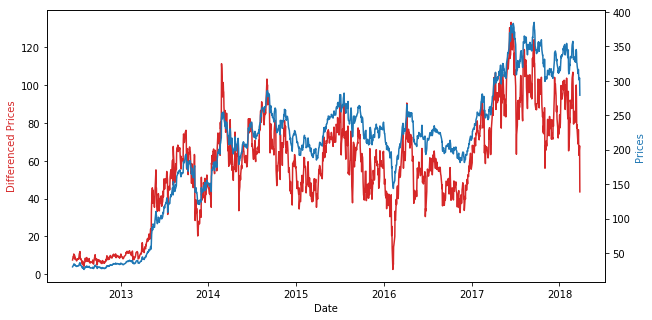

In [27]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Differenced Prices', color=color)
ax1.plot(df_result.index, df_result['Adj. Close'], color=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Prices', color = color)
ax2.plot(df_result.index, tsla['Adj. Close'].values[-(df_result.shape[0]):], color=color)

plt.show()

Just a reminder that we dont have (and can never have) a fractionally differenced value for every time series point in our data. Since we need to use the previous n points (n being our width) to compute the n+1'th point, the first n points are unavailable for use to compute fractional differences for (in this method at least, since it is a fixed window). 

We could adjust our threshold values or differencing parameters but we will soon see how this affects the stationarity of our results. 

Just to make sure, lets use a few tests of stationarity and take a look at our results for the various values of d. 

### Dickey-Fuller, Kwiatowski-Phillips-Schmidt-Shin and the Path to Stationarity

Before I get into who all these guys are and why they all decided to name their discoveries after themselves (whoever said mathematicians weren't egotistical?), let's take a deeper look at stationarity. 

Reminding ourselves what this means exactly: 

*'A stationary time series is one where the mean (average value) and variance (spread of values) is constant over time.'*


Although this explanation gives us a rough idea of what stationarity entails, it fails to dive into the details that are key to understanding how we go about testing it. Thus, I provide an explanation from a different angle, what stationarity **Is Not**:

*'A non-stationary process (or unit-root process) is a process that contains a stochastic trend over time (a systematic pattern over time). There is no long-run mean or variance.'*


What the hell is a unit-root you may ask? I'm glad you asked! I spent some time coming up with an intuitive explanation (with the help of good ol' google) that I think anyone can understand.


#### Unit Root: An Analogy

So lets say you go camping. While wandering around the forest looking for a good campsite, you find a bridge and a river running below it. You decide to cross it and not looking exactly where you're going, you accidentally trip over a wooden plank. The water bottle you were holding jerks out of your hand and into the river.

You see it floating slowly under the bridge and decide to take a closer look. You notice that it fell on the left side of the bridge and got taken to the right. You wonder if it would do it again?

Lets say the flow along the surface of the water looked like the following:

<img src="river_flow_1.png" width= "500">

The arrows show the direction of flow and are connected by streamlines. The water bottle you drop will tend to follow the streamline in which it falls. BUT (and this is key here), it doesn't exactly. There are random variations along the path since water flow changes over time. This could be due to strong wind, a fish, a large rock in the river or any of the other complex dynamics of flow at play. 

You can see that regardless of where we end up dropping our water bottle (assuming we did so on the left side of the diagram), it ends up flowing towards the right, although not linearly.

The stream inevitably carries the water bottle to the top right, it *trends* over time. Regardless of the random gyrations of the water, the flow of the river accelerates towards a particular point in the top right. (We're almost home clear here!)

Associated with the speed of acceleration, is what we call a "root". When the size of this root is greater than unity (or mathematically, 1), the series cannot be stationary. 

#### The ADF and KPSS Tests for stationarity

Phew! That wasn't so bad was it? Don't fret over why exactly a unit root means non-stationarity (although if you're interested, [here](https://en.wikipedia.org/wiki/Unit_root) is a link) since it isn't really the purpose of this post. Just know that there are many forms of non-stationarity and a unit root is just one of them (a REALLY important one at that). 

Now lets get back to the math and take a look at some classical stationarity tests to see how our fractionally differenced series holds up.


**1.) ADF Test**: This test is used to detect the presence of a unit-root.

**2.) KPSS Test**: This test is used to detect the presence of trend-stationarity around a deterministic trend.

These two tests are meant to complement each other. By testing both the unit-root and trend-stationarity, it gives us a better idea of where we can categorize the stochastic behaviour of our data. I run both these tests below. 

In [10]:
#Running the adf test and displaying results

adf_result = st.adfuller(df_result['Adj. Close'], regression = 'ctt', store = True)

print("ADF Test Results: ")
print("Test Statistic: %.4f" % adf_result[0])
print("p-value: %.10f" % adf_result[1])
print("Critical Values: ")
for key, value in adf_result[2].items():
    print('\t%s: %0.3f' % (key, value))


ADF Test Results: 
Test Statistic: -6.8762
p-value: 0.0000001550
Critical Values: 
	1%: -4.383
	5%: -3.838
	10%: -3.557


Now, lets break down our results. What is of most concern to us is our p-value. In this test, our p-value is the following:

*Assuming that our series has a unit root, (or is non-stationary) we would obtain these results in 0.0000155% through random-sampling and re-testing. Essentially, there is a very low likelihood that our series is in fact non-stationary*

So this is definitely a good thing since such a low p-value is basically telling us there is no unit root (and hence no non-stationary trend in our data).

BUT, is that enough? Not quite... We still would like to see if our earlier hypothesis of trend stationarity is consistent, so we turn to the KPSS test. 

In [11]:
#Running the kpss test and displaying results
kpss_result = st.kpss(df_result['Adj. Close'], store=True)

print("KPSS Test Results: ")
print("Test Statistic: %.4f" % kpss_result[0])
print("p-value: %.10f" % kpss_result[1])
print("Critical Values: ")
for key, value in kpss_result[2].items():
    print('\t%s: %0.3f' % (key, value))

KPSS Test Results: 
Test Statistic: 0.2992
p-value: 0.1000000000
Critical Values: 
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


/Users/28422/Desktop/Blog_files/jupyter-env/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


(Note, the warning came because the true p-value is actually above 0.1 but this only further helps the case we are trying to prove).

In this case, we can interpret our p-value as the following:

*Assuming our series is trend-stationary, we would obtain these results in at least 10% of our results through random-sampling and re-testing. (The at-least 10% is due to the fact that the test cannot give us p-values higher than 0.10 or 10%).*

Although at least 10% doesn't sound like a whole lot, it definitely is in statistics. This test also further shows that our series is in-fact very likely to be trend-stationary. 

### Varying Starting Conditions: How do test results fare?

So, whats next? Well, I am a bit curious to see how our test results change as our differencing parameter changes. So, below, lets look at how changing our threshold value (for fractional differencing coefficients) and differencing factors change the results of the adf test results. 

I also decide to take a look at how these parameters change the number of data points we are able to difference (or the length of the differenced series). 

In [12]:
pd.options.display.float_format = '{:.5f}'.format

#the 130 combinations to test, varying values of our thresholds and differencing factors
thresh_values = [1e-3, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 9e-5, 7e-5, 5e-5, 3e-5]
diff_values = [0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2]

#dataframe to hold results
pval_hyperparam_df = pd.DataFrame(0.1, columns = thresh_values, index=diff_values)

#dataframe to hold lengths 
lengths_df = pd.DataFrame(1, columns = thresh_values, index = diff_values)

#to keep track of column and row indices when placing results in dataframe
col = 0
row = 0

#cycle through each combination of threshold values and diff values
    # and generate adf test-statistics for each combination
for i in thresh_values:
    for j in diff_values:
        
        #fractionally difference series and store series lengths
        test_diff_series = fracDiff(test_series, j, i)
        lengths_df.iat[row,col] = test_diff_series.shape[0]
        
        #run and collect adf fuller test
        test_adf_result = st.adfuller(test_diff_series['Adj. Close'], regression = 'ctt', store = True)
        
        pval_hyperparam_df.iat[row, col] = test_adf_result[0]
        
        row += 1
    row = 0
    col += 1
    
#display our results
display(pval_hyperparam_df)
display(lengths_df)

,0.001,0.0009,0.0007,0.0005,0.0003,0.0001,9e-05,7e-05,5e-05,3e-05
0.80000,-10.94652,-11.00533,-11.04233,-11.08483,-11.07969,-10.95621,-10.93916,-10.89717,-10.84898,-10.71649
0.75000,-10.21107,-10.24159,-10.32522,-10.37026,-10.37648,-10.25487,-10.23890,-10.20903,-10.11115,-9.94652
0.70000,-9.48848,-9.51605,-9.59684,-9.66404,-9.68291,-9.57725,-9.53761,-9.46933,-9.35830,-9.17454
0.65000,-8.77627,-8.79895,-8.90477,-8.97096,-8.99766,-8.84903,-8.81612,-8.73200,-8.61191,-8.39907
0.60000,-8.07450,-8.11659,-8.21123,-8.28918,-8.32554,-8.13446,-8.09516,-8.00774,-7.87333,-7.61759
...,...,...,...,...,...,...,...,...,...,...
0.40000,-5.61061,-5.64819,-5.73725,-5.82995,-5.81907,-5.45001,-5.39168,-5.23933,-5.03168,-5.79583
0.35000,-5.07583,-5.11660,-5.19699,-5.29747,-5.24415,-4.84901,-4.78709,-4.62653,-4.47523,-5.40008
0.30000,-4.57857,-4.62001,-4.71025,-4.77921,-4.72640,-4.29549,-4.23193,-4.09259,-4.91650,-4.45010
0.25000,-4.12678,-4.15993,-4.26787,-4.28243,-4.24922,-4.35738,-4.29567,-4.23346,-4.76576,-3.28458


,0.001,0.0009,0.0007,0.0005,0.0003,0.0001,9e-05,7e-05,5e-05,3e-05
0.80000,1932,1930,1928,1923,1915,1886,1882,1872,1856,1826
0.75000,1928,1927,1923,1918,1907,1871,1866,1853,1833,1793
0.70000,1924,1923,1919,1912,1899,1853,1847,1831,1805,1754
0.65000,1920,1919,1913,1905,1890,1833,1825,1805,1772,1708
0.60000,1916,1914,1908,1898,1879,1810,1800,1775,1734,1653
...,...,...,...,...,...,...,...,...,...,...
0.40000,1895,1891,1879,1860,1821,1668,1646,1586,1488,1284
0.35000,1889,1884,1871,1849,1802,1618,1591,1518,1395,1141
0.30000,1884,1878,1863,1837,1783,1562,1530,1440,1290,973
0.25000,1879,1873,1856,1827,1765,1505,1466,1358,1176,785


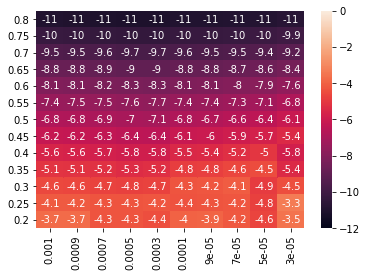

In [13]:
#Heatmap plot just so we get a better idea of how these changes are happening
heatmap = sns.heatmap(pval_hyperparam_df, vmin=0, vmax=-12, annot=True)

We see that higher amounts of differencing do typically lead to much more negative test-statistics (which translate to very low p-values).  All in all, this basically tells us that as we increase our differencing factor  our series becomes more stationary. This would make sense since we typically take first differences (d=1) to get returns which are considered stationary. 

What this chart highlights is the fact that we don't actually have to overly difference a series to get trend-stationarity in the underlying series. 

Also notice that lowering our threshold, holding the differencing-factor constant, lowers the number of observations we can difference (and this is much more pronounced for lower differencing factors since the values converge much quicker). The same can be said for holding our threshold constant and decreasing our differencing factor. 

### Pitfalls, Limitations, Conclusions

So, why do we need to be careful about what we've been studying here? Well, for the ADF test in particular, testing for a unit-root and testing for trend-stationarity aren't exactly the same thing. The weird thing is, it is possible for a time series to be non-stationary but have no unit root. 

Trend-stationary tests (like the KPSS test) are really looking for time-series convergence around a certain mean, and this mean can grow or shrink over time. Unit root processes however, assume that shocks to our series have a permanent impact. 

Also, in the presence of time-varying variance (which is the case in some of the computed examples above), our results becomes less robust (although this can be easily fixed by conducting other unit root tests such as the Phillips-Peron test that is more robust to heteroskedasticity). 

#### Final Thoughts

So, what exactly has this series of posts shown? Virtually all finance papers apply integer differencing (a factor of 1) and is usually overkill for most financial time-series. This over-differencing causes most if not all memory to be lost, leaving us very little with regard to information in using prices in statistical models. 

I'll conclude with a thought that radically shifted my perspective on quantitative trading:


It's important to think about quantitative trading from a statistical framework. The price path you see in a chart is simply a realized price path, generated from an underlying distribution (that we, unfortunately, don't know much about). Going forward, under repeated sampling, we have to assume that other price paths are also very likely. 

Thinking about equity curves and time-series paths in this manner definitely make things more confusing but solidify why statistical ideas, although complex on the surface, are so useful and powerful in giving quants an edge. 